<b>Goal of the project:</b> find the best model to predict next 7 days of my dog's daily consumption.
<br><b>Dataset:</b> I use the dataset made by myself. I note my dog's each meal in the dataset to track his appetite which might be helpful to identify potential sickness and find reasons behind amount of food consumed in a day (e.g. he has been eating a lot for the last 2 days, so lower appetite the following day should not be surprising).
<br><b>Additional details:</b> My dog is a male shiba, born in September 2024, so it is expected his appetite in the first months of the dataset could be strongly affected by the early-puppyhood weight gain process. This issue is examined the Data Preparation section to determine whether the dataset should be sliced.
<br><br><b>Applied methods:</b>
<ul>
    <li>Simple Exponential Smoothing</li>
    <li>Double Exponential Smoothing</li>
    <li>Triple Exponential Smoothing (Holt-Winters)</li>
    <li>ARIMA</li>
    <li>Prophet</li>
</ul>
<b>Important notes:</b>
<ul>
    <li>To keep the project's size acceptable and due to the lack of time it has been decided not to include seasonality as a vital part of this project at the moment. I am aware including a seasonality may improve the project, so I take into account adding this in a future.</li>
    <li>I am aware day-to-day changes can be just a random fluctuation or caused by an external factor (exogenous variable) like temperature. To keep the project's size acceptable and due to the lack of time it has been decided not to include exogenous variables this time.</li>
    <li>Parameter tuning is applied only to selected methods depending on their complexity. Thus, Exponential Smoothing methods will rely on base scenarios (additive trend and autocorrelation-based component).</li>
    <li>Forecast horizon (7 days) is arbitrary.</li>
</ul>

# Libraries and setup

In [1]:
# All-purpose libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
#import os

# Exploratory data analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Time series modeling methods and additional functions
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import arch
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch

from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly
import plotly.offline as py

# Cross-valiadtion and parameter tuning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid

# Model evaluation
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Setup
warnings.filterwarnings('ignore')
np.set_printoptions(legacy='1.25')

# Useful functions

In [2]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
    plt.figure(figsize = (10, 4))

    plt.plot(train, label = 'Train')
    plt.plot(test, label = 'Test')
    plt.plot(predictions, label = "Forecast")
    
    plt.title(f"Train, Test and Predictions with {chart_title}")
    plt.legend()
    plt.show()
    
    # Calculating the RMSE, MAE and MAPE
    rmse = root_mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    mape = mean_absolute_percentage_error(test, predictions)
    
    # Print the calculated error metrics
    print(f"The RMSE is {rmse:.2f}")
    print(f"The MAE is {mae:.2f}")
    print(f"The MAPE is {100 * mape:.2f} %")

    return rmse, mae, mape
    

# Data preparation

## Loading dataset

In [3]:
#os.chdir("nauka\pies")
#os.getcwd()

In [4]:
raw_df = pd.read_excel("dog_data.xlsx", index_col=0, parse_dates=True, usecols=list(range(3, 5)))
raw_df.index.name="date"
raw_df.rename(columns={'Suma z porcja [g]': 'consumption [g]'}, inplace=True)
raw_df.index.freq='D'

In [5]:
weight_df = pd.read_excel("dog_data.xlsx", index_col=0, parse_dates=True, usecols=list(range(0, 2)))
raw_df.index.name='date'
weight_df.dropna(inplace=True)
weight_df.rename(columns={'waga psa [kg]': 'dog weight [kg]'}, inplace=True)
weight_df['diff [kg]'] = weight_df.diff()
weight_df['diff [%]'] = weight_df['dog weight [kg]'].pct_change() * 100

## EDA and dataset slicing

Taking into account I am the author of the dataset, I do not need to use basic Pandas' EDA methods like .info(), .describe(). If it was an external dataset, I would use them.

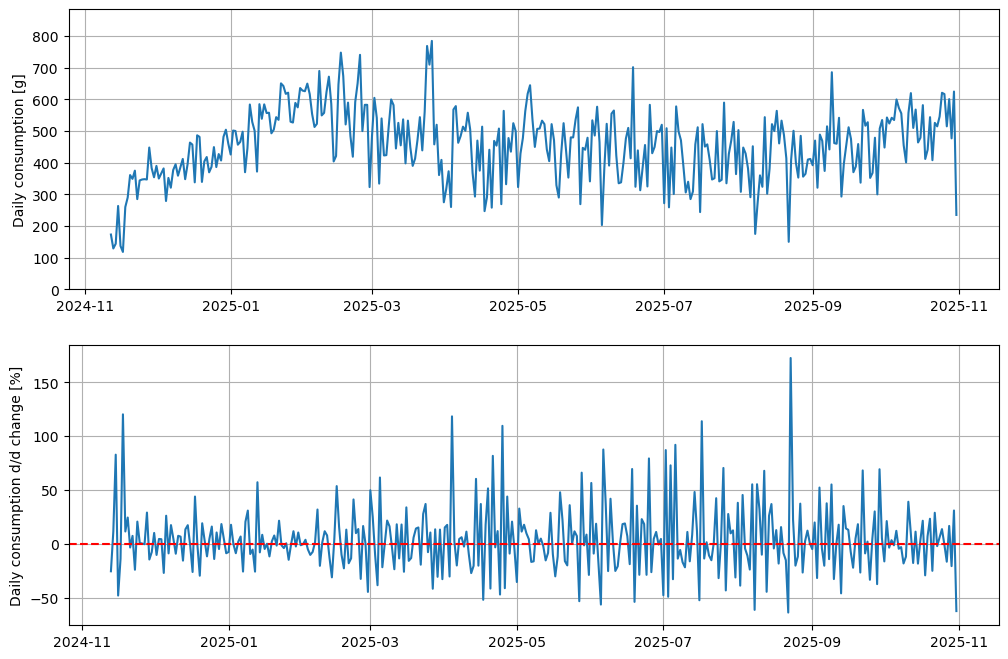

In [6]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(raw_df)
plt.ylabel('Daily consumption [g]')
plt.ylim(bottom=0, top=max(raw_df['consumption [g]'])+100)
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(raw_df.pct_change()*100)
plt.ylabel('Daily consumption d/d change [%]')
plt.axhline(y=0, color='r', ls='--')
#plt.hlines(y=0, color='r', ls='--', xmin=min(raw_df.index), xmax=max(raw_df.index))
plt.grid()

plt.show()

In [7]:
# Dropped the last column to because sometimes that day's data may not be completed yet
df = raw_df.iloc[:-1, :]
df.tail()

consumption [g]
date                       
2025-10-26            617.0
2025-10-27            515.0
2025-10-28            601.0
2025-10-29            477.0
2025-10-30            625.0

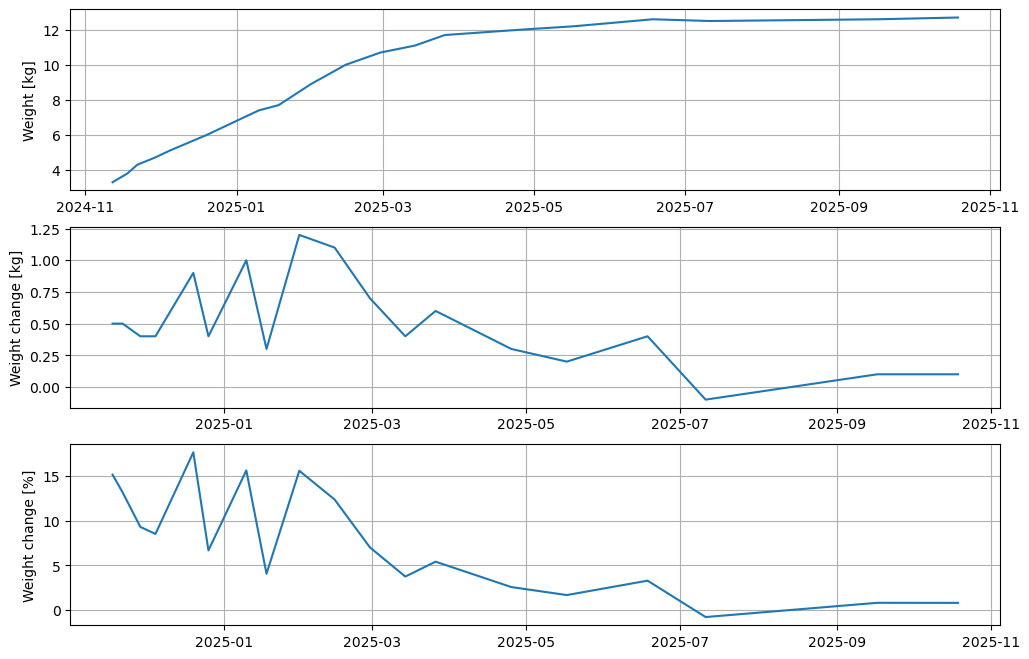

In [8]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(weight_df['dog weight [kg]'])
plt.ylabel('Weight [kg]')
#plt.ylim(bottom=0, top=max(weight_df)+100)
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(weight_df['diff [kg]'])
plt.ylabel('Weight change [kg]')
#plt.hlines(y=0, color='r', ls='--', xmin=min(raw_df.index), xmax=max(raw_df.index))
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(weight_df['diff [%]'])
plt.ylabel('Weight change [%]')
plt.grid()

plt.show()

Average male shiba reaches ~10-12 kg, so date of reaching a weight in this area can be treated as the end of the dog's early puppyhood and beginning of the dataset. Around March both appetite and weight gain pace decreased. Thus, the March 1st is treated as the first day of the dataset

In [9]:
df = df.loc['2025-03-01':]
plt.figure(figsize=(12, 6))
plt.plot(df)
plt.ylabel('Daily consumption [g]')
plt.ylim(bottom=0)
plt.grid()
plt.title('Sliced dataset')
plt.show()

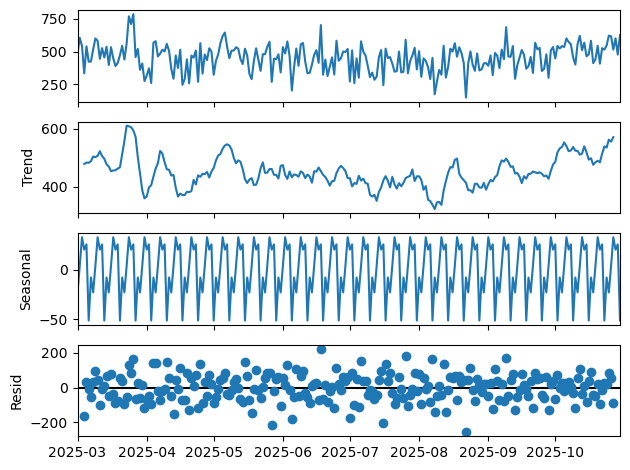

In [10]:
seasonal_decompose(df, model='additive').plot();

Data does not show any multiplicative behavior. Taking this into account, data trends are assumed to be additive.

## Train-test split

In [11]:
periods = 7
train = df.iloc[:-periods]
test = df.iloc[-periods:]

## Autocorrelations

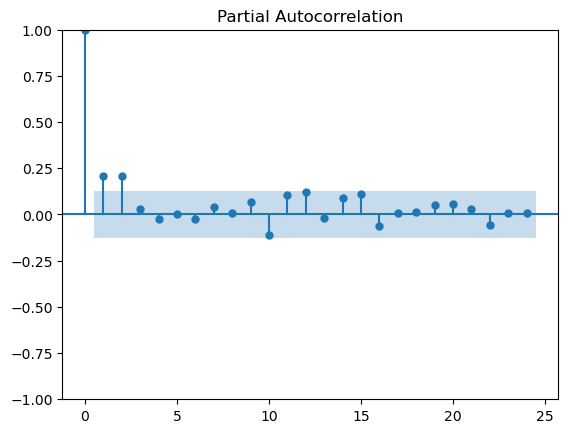

In [12]:
plot_acf(df)
plot_pacf(df);

Basing on the default intervals, ACF (q) and PACF (p) values for lags 1 and 2 are barely significant. Daily consumption does not seem to be strongly related to past values (in other words, applied methods may not provide satisfying results).

# Simple Exponential Smoothing

In [13]:
ses_model = SimpleExpSmoothing(train).fit()
ses_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       SimpleExpSmoothing Model Results                       
==============================================================================
Dep. Variable:        consumption [g]   No. Observations:                  237
Model:             SimpleExpSmoothing   SSE                        2417054.762
Optimized:                       True   AIC                           2191.510
Trend:                           None   BIC                           2198.446
Seasonal:                        None   AICC                          2191.682
Seasonal Periods:                None   Date:                 Fri, 31 Oct 2025
Box-Cox:                        False   Time:                         15:44:13
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.0614615                alpha                 True
initial_level              484.00000                  l.0                False
------------------------------------------------------------------------------
"""

In [14]:
ses_pred = ses_model.forecast(periods)
ses_rmse, ses_mae, ses_mape = model_assessment(train.loc['2025-09':], test, ses_pred, 'Simple Exponential Smoothing')

The RMSE is 96.84
The MAE is 84.09
The MAPE is 14.01 %


# Double Exponential Smoothing

In [15]:
model_double = ExponentialSmoothing(train, trend='additive', seasonal=None).fit()
model_double.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:          consumption [g]   No. Observations:                  237
Model:             ExponentialSmoothing   SSE                        2416745.638
Optimized:                         True   AIC                           2195.480
Trend:                         Additive   BIC                           2209.352
Seasonal:                          None   AICC                          2195.845
Seasonal Periods:                  None   Date:                 Fri, 31 Oct 2025
Box-Cox:                          False   Time:                         15:44:13
Box-Cox Coeff.:                    None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.0621337                alpha                 True
smoothing_trend             0.000000                 beta                 True
initial_level              489.96379                  l.0                 True
initial_trend              0.0095863                  b.0                 True
------------------------------------------------------------------------------
"""

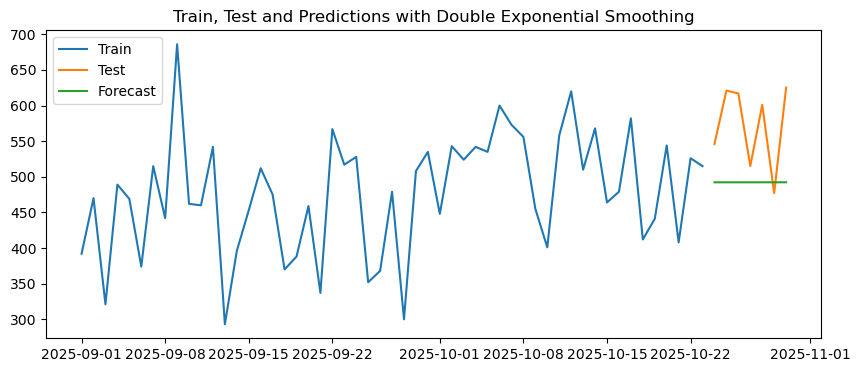

The RMSE is 96.51
The MAE is 83.81
The MAPE is 13.96 %


In [16]:
double_pred = model_double.forecast(periods)
double_rmse, double_mae, double_mape = model_assessment(train.loc['2025-09':], test, double_pred, 'Double Exponential Smoothing')

# Triple Exponential Smoothing (Holt-Winters)

Seasonal periods has been assumed using autocorrelation plots.

In [17]:
model_holt = ExponentialSmoothing(train, trend='additive', seasonal='additive', seasonal_periods=2).fit()
model_holt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:          consumption [g]   No. Observations:                  237
Model:             ExponentialSmoothing   SSE                        2393097.439
Optimized:                         True   AIC                           2197.149
Trend:                         Additive   BIC                           2217.958
Seasonal:                      Additive   AICC                          2197.781
Seasonal Periods:                     2   Date:                 Fri, 31 Oct 2025
Box-Cox:                          False   Time:                         15:44:14
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0626201                alpha                 True
smoothing_trend                0.000000                 beta                 True
smoothing_seasonal             0.000000                gamma                 True
initial_level                 483.19872                  l.0                 True
initial_trend                 0.0220113                  b.0                 True
initial_seasons.0            -7.6522047                  s.0                 True
initial_seasons.1             11.868533                  s.1                 True
---------------------------------------------------------------------------------
"""

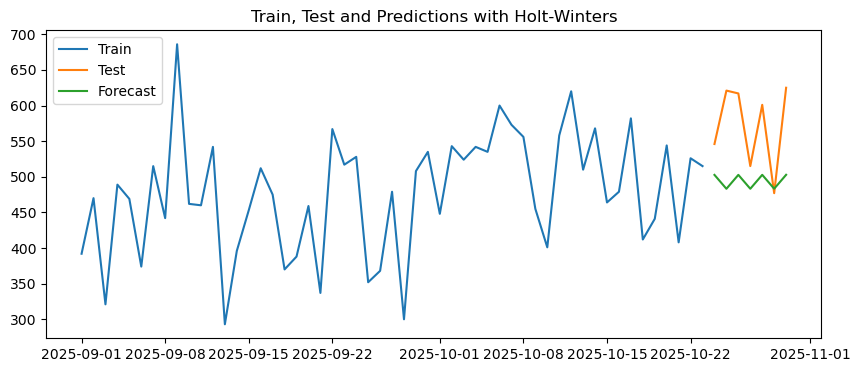

The RMSE is 92.25
The MAE is 79.13
The MAPE is 13.15 %


In [18]:
holt_pred = model_holt.forecast(periods)
holt_rmse, holt_mae, holt_mape = model_assessment(train.loc['2025-09':], test, holt_pred, 'Holt-Winters')

# Exponential Smoothing summary

In [19]:
pd.DataFrame(data=[ses_model.params, model_double.params, model_holt.params], index=['Simple ES', 'Double ES', 'Triple ES'])

smoothing_level  smoothing_trend  smoothing_seasonal  \
Simple ES         0.061462              NaN                 NaN   
Double ES         0.062134              0.0                 NaN   
Triple ES         0.062620              0.0                 0.0   

           damping_trend  initial_level  initial_trend  \
Simple ES            NaN     484.000000            NaN   
Double ES            NaN     489.963794       0.009586   
Triple ES            NaN     483.198725       0.022011   

                                    initial_seasons  use_boxcox lamda  \
Simple ES                                        []       False  None   
Double ES                                        []       False  None   
Triple ES  [-7.652204662908227, 11.868533214916956]       False  None   

           remove_bias  
Simple ES        False  
Double ES        False  
Triple ES        False

In [20]:
es_metrics = pd.DataFrame(
    data={
        'RMSE': [ses_rmse, double_rmse, holt_rmse], 
        'MAE': [ses_mae, double_mae, holt_mae], 
        'MAPE': [ses_mape, double_mape, holt_mape]
         }, 
    index=['Simple ES', 'Double ES', 'Triple ES']
)
es_metrics

RMSE        MAE      MAPE
Simple ES  96.840758  84.090128  0.140075
Double ES  96.511850  83.809591  0.139619
Triple ES  92.246783  79.131003  0.131477

# ARIMA

## Testing stationarity

To make a reliable ARIMA model it is needed to check stationarity which is done by the Augmented Dickey-Fuller test.

In [21]:
adf_res = adfuller(df)
print(f'ADF statistic: {adf_res[0]}')
print(f'p-value: {adf_res[1]}')
if adf_res[1] < 0.05:
    print('The series is stationary.')
    print('The series is ready to be inputed into a model.')
else:
    print('The series is NOT stationary.')
    print('The series needs to modified e.g. set different range of differentate the series') 

ADF statistic: -7.82659517528816
p-value: 6.457003814131565e-12
The series is stationary.
The series is ready to be inputed into a model.


## Estimating parameters

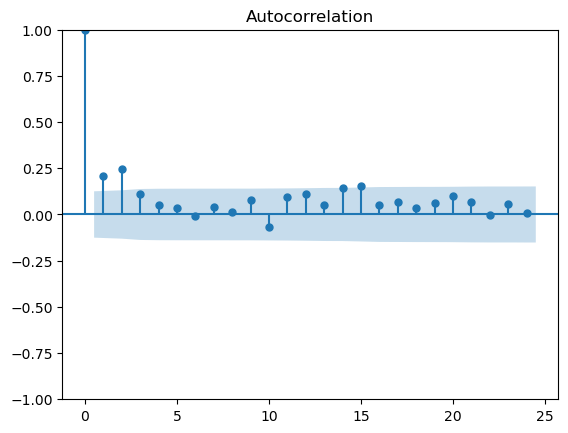

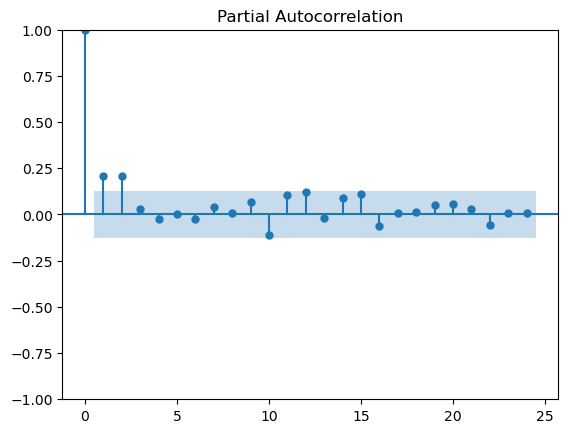

In [22]:
plot_acf(df)
plot_pacf(df);

In [23]:
pq = []
aic = []
bic = []
for p in range(0, 8):
    for q in range(0, 8):
        model = SARIMAX(df, order=(p, 0, q), seasonal_order=(0, 0, 0, 0))
        res = model.fit()
        pq.append( (p, 0, q) )
        aic.append(res.aic)
        bic.append(res.bic)
    print(f'Models for the p={p} have been done.')
results = pd.DataFrame(data={'p q': pq, 'aic': aic, 'bic': bic})
results.set_index('p q', inplace=True)
print(f'The lowest AIC value is for the {results['aic'].idxmin()}', 
      f'The lowest BIC value is for the {results['bic'].idxmin()}', 
      sep='\n')

Models for the p=0 have been done.
Models for the p=1 have been done.
Models for the p=2 have been done.
Models for the p=3 have been done.
Models for the p=4 have been done.
Models for the p=5 have been done.
Models for the p=6 have been done.
Models for the p=7 have been done.
The lowest AIC value is for the (1, 0, 3)
The lowest BIC value is for the (1, 0, 1)


In [24]:
results.plot()

<Axes: xlabel='p q'>

In [25]:
results.sort_values(by='aic', ascending=True).head(8)

aic          bic
p q                                
(1, 0, 3)  2949.625967  2967.111809
(3, 0, 1)  2949.667689  2967.153530
(1, 0, 4)  2951.030664  2972.013674
(2, 0, 3)  2951.093877  2972.076886
(4, 0, 1)  2951.666011  2972.649020
(5, 0, 1)  2952.651823  2977.132001
(4, 0, 2)  2953.071967  2977.552145
(2, 0, 4)  2953.129081  2977.609258

According to above values, the best results (lowest AIC and BIC) are for p and q values equal to 5 or less. Thus, this range of values (range(1, 6)) will be tested.

In [26]:
# Define the parameter options
param_grid = {
    'p': [1, 2, 3, 4, 5], 
    'd': [0], 
    'q': [1, 2, 3, 4, 5]
}
grid = ParameterGrid(param_grid)

# Do the time series splits
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=periods)

In [27]:
# Perform parameter tuning
rmse_list = []
mae_list = []
mape_list = []

# Iterate over the parameters
for params in grid:
    fold_rmse = []
    fold_mae = []
    fold_mape = []

    # Build the model
    for train_index, test_index in tscv.split(df):
        train = df.iloc[train_index]
        test = df.iloc[test_index]
        
        # ARIMA
        model_arima = SARIMAX(
            train['consumption [g]'], 
            order=(params['p'], params['d'], params['q']), 
            seasonal_order=(0, 0, 0, 0)
        ).fit()

        # Make predictions, calculate the error and store results
        predictions_arima = model_arima.forecast(steps=periods)

        # Assess the predictions
        rmse = root_mean_squared_error(test['consumption [g]'], predictions_arima)
        mae = mean_absolute_error(test['consumption [g]'], predictions_arima)
        mape = mean_absolute_percentage_error(test['consumption [g]'], predictions_arima)
        fold_rmse.append(rmse)
        fold_mae.append(mae)
        fold_mape.append(mape)
    
    # Store the results
    rmse_list.append(np.mean(fold_rmse))
    mae_list.append(np.mean(fold_mae))
    mape_list.append(np.mean(fold_mape))

    print(f'Params {params} are completed')
    

Params {'d': 0, 'p': 1, 'q': 1} are completed
Params {'d': 0, 'p': 1, 'q': 2} are completed
Params {'d': 0, 'p': 1, 'q': 3} are completed
Params {'d': 0, 'p': 1, 'q': 4} are completed
Params {'d': 0, 'p': 1, 'q': 5} are completed
Params {'d': 0, 'p': 2, 'q': 1} are completed
Params {'d': 0, 'p': 2, 'q': 2} are completed
Params {'d': 0, 'p': 2, 'q': 3} are completed
Params {'d': 0, 'p': 2, 'q': 4} are completed
Params {'d': 0, 'p': 2, 'q': 5} are completed
Params {'d': 0, 'p': 3, 'q': 1} are completed
Params {'d': 0, 'p': 3, 'q': 2} are completed
Params {'d': 0, 'p': 3, 'q': 3} are completed
Params {'d': 0, 'p': 3, 'q': 4} are completed
Params {'d': 0, 'p': 3, 'q': 5} are completed
Params {'d': 0, 'p': 4, 'q': 1} are completed
Params {'d': 0, 'p': 4, 'q': 2} are completed
Params {'d': 0, 'p': 4, 'q': 3} are completed
Params {'d': 0, 'p': 4, 'q': 4} are completed
Params {'d': 0, 'p': 4, 'q': 5} are completed
Params {'d': 0, 'p': 5, 'q': 1} are completed
Params {'d': 0, 'p': 5, 'q': 2} ar

In [28]:
metrics_df = pd.DataFrame(list(grid))
metrics_df['rmse'] = rmse_list
metrics_df['mae'] = mae_list
metrics_df['mape'] = mape_list
metrics_df

d  p  q       rmse        mae      mape
0   0  1  1  85.754764  75.671671  0.147772
1   0  1  2  87.480109  77.320117  0.149653
2   0  1  3  91.173347  81.098968  0.156096
3   0  1  4  92.014364  81.978769  0.157396
4   0  1  5  92.974350  82.412792  0.157869
5   0  2  1  88.476669  78.217849  0.150865
6   0  2  2  86.241512  76.659893  0.150278
7   0  2  3  91.700339  81.786507  0.157154
8   0  2  4  91.530305  81.342111  0.156635
9   0  2  5  92.257006  82.610955  0.158999
10  0  3  1  92.128241  82.148577  0.157961
11  0  3  2  88.278469  78.401288  0.152052
12  0  3  3  84.602381  73.573428  0.143341
13  0  3  4  92.015121  81.260980  0.155402
14  0  3  5  96.922991  87.033903  0.169729
15  0  4  1  97.161176  86.708266  0.165638
16  0  4  2  92.411185  82.890862  0.159800
17  0  4  3  92.207952  80.496976  0.153447
18  0  4  4  85.631356  75.962354  0.147653
19  0  4  5  88.456491  78.886582  0.151887
20  0  5  1  92.542240  81.923270  0.156554
21  0  5  2  92.917832  83.699612  0.161670
22  0  5  3  96.845728  85.630681  0.165106
23  0  5  4  89.080728  79.319290  0.152958
24  0  5  5  93.843952  80.601668  0.158890

In [29]:
if metrics_df.loc[metrics_df['rmse'].idxmin()].equals(metrics_df.loc[metrics_df['mae'].idxmin()]) and metrics_df.loc[metrics_df['rmse'].idxmin()].equals(metrics_df.loc[metrics_df['mape'].idxmin()]):
    print('RMSE, MAE and MAPE metrics have the lowest values for the same model')
else:
    print('RMSE, MAE and MAPE metrics have the lowest values for different models')

RMSE, MAE and MAPE metrics have the lowest values for the same model


In [30]:
arima_params = grid[metrics_df['rmse'].idxmin()]

## Running the final model 

In [31]:
model_arima = SARIMAX(
        train['consumption [g]'], 
        order=(arima_params['p'], arima_params['d'], arima_params['q']), 
        seasonal_order=(0, 0, 0, 0)
    ).fit()
arima_pred = model_arima.forecast(steps=periods)

In [32]:
arima_rmse, arima_mae, arima_mape = model_assessment(train.loc['2025-09':], test, arima_pred, 'ARIMA')

The RMSE is 93.71
The MAE is 80.17
The MAPE is 13.34 %


In [33]:
arima_mape

0.1333517377495769

In [34]:
arima_metrics = pd.DataFrame(data={'RMSE': arima_rmse, 'MAE': arima_mae, 'MAPE': arima_mape}, index=['ARIMA'])
arima_metrics

RMSE        MAE      MAPE
ARIMA  93.711411  80.167501  0.133352

# Prophet

## Adjusting dataframe to Prophet

In [35]:
prophet_df = df.reset_index()
prophet_df.rename(columns={'date': 'ds', 'consumption [g]': 'y'}, inplace=True)
prophet_train = prophet_df.iloc[:-periods]
prophet_test = prophet_df.iloc[-periods:]

In [36]:
prophet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      244 non-null    datetime64[ns]
 1   y       244 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9 KB


## Estimating parameters

In [37]:
prophet_param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5], # The higher, the trend is more vulnerable to noise
    'n_changepoints': [10, 20, 40], # Max number of potential trend change locations
    'changepoint_range': [0.8, 0.9, 1.0] # Fraction of the history where changepoints are allowed
}
grid = ParameterGrid(prophet_param_grid)

In [38]:
# Perform parameter tuning
rmse_list = []
mae_list = []
mape_list = []

# Iterate over the parameters
for params in grid:
    fold_rmse = []
    fold_mae = []
    fold_mape = []

    prophet_model = Prophet(
        yearly_seasonality=False, 
        weekly_seasonality=False, 
        daily_seasonality=False,
        **params
    ).fit(prophet_train)

    # Cross-Validations
    df_cv = cross_validation(model=prophet_model, period='7 days', initial='180 days', horizon='7 days', parallel='processes')

    # Calculate performance metrics
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    # Store the results
    rmse_list.append(df_p['rmse'].values[0])
    mae_list.append(df_p['mae'].values[0])
    mape_list.append(df_p['mape'].values[0])

    print(f'Params {params} are completed')

15:46:05 - cmdstanpy - INFO - Chain [1] start processing
15:46:05 - cmdstanpy - INFO - Chain [1] done processing
15:46:09 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'n_changepoints': 10} are completed


15:46:09 - cmdstanpy - INFO - Chain [1] done processing
15:46:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] done processing
15:46:13 - cmdstanpy - INFO - Chain [1] start processing
15:46:13 - cmdstanpy - INFO - Chain [1] done processing
15:46:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'n_changepoints': 20} are completed


Optimization terminated abnormally. Falling back to Newton.
15:46:13 - cmdstanpy - INFO - Chain [1] start processing
15:46:14 - cmdstanpy - INFO - Chain [1] done processing
15:46:20 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'n_changepoints': 40} are completed


15:46:20 - cmdstanpy - INFO - Chain [1] done processing
15:46:24 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'n_changepoints': 10} are completed


15:46:24 - cmdstanpy - INFO - Chain [1] done processing
15:46:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:46:24 - cmdstanpy - INFO - Chain [1] start processing
15:46:24 - cmdstanpy - INFO - Chain [1] done processing
15:46:28 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'n_changepoints': 20} are completed


15:46:28 - cmdstanpy - INFO - Chain [1] done processing
15:46:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:46:28 - cmdstanpy - INFO - Chain [1] start processing
15:46:29 - cmdstanpy - INFO - Chain [1] done processing
15:46:36 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'n_changepoints': 40} are completed


15:46:36 - cmdstanpy - INFO - Chain [1] done processing
15:46:39 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 1.0, 'n_changepoints': 10} are completed


15:46:39 - cmdstanpy - INFO - Chain [1] done processing
15:46:43 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 1.0, 'n_changepoints': 20} are completed


15:46:43 - cmdstanpy - INFO - Chain [1] done processing
15:46:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:46:43 - cmdstanpy - INFO - Chain [1] start processing
15:46:44 - cmdstanpy - INFO - Chain [1] done processing
15:46:51 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 1.0, 'n_changepoints': 40} are completed


15:46:51 - cmdstanpy - INFO - Chain [1] done processing
15:46:55 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'n_changepoints': 10} are completed


15:46:55 - cmdstanpy - INFO - Chain [1] done processing
15:46:58 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'n_changepoints': 20} are completed


15:46:58 - cmdstanpy - INFO - Chain [1] done processing
15:47:02 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'n_changepoints': 40} are completed


15:47:02 - cmdstanpy - INFO - Chain [1] done processing
15:47:06 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'n_changepoints': 10} are completed


15:47:06 - cmdstanpy - INFO - Chain [1] done processing
15:47:10 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'n_changepoints': 20} are completed


15:47:10 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'n_changepoints': 40} are completed


15:47:14 - cmdstanpy - INFO - Chain [1] start processing
15:47:14 - cmdstanpy - INFO - Chain [1] done processing
15:47:18 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 1.0, 'n_changepoints': 10} are completed


15:47:18 - cmdstanpy - INFO - Chain [1] done processing
15:47:22 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 1.0, 'n_changepoints': 20} are completed


15:47:22 - cmdstanpy - INFO - Chain [1] done processing
15:47:26 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 1.0, 'n_changepoints': 40} are completed


15:47:26 - cmdstanpy - INFO - Chain [1] done processing
15:47:30 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8, 'n_changepoints': 10} are completed


15:47:30 - cmdstanpy - INFO - Chain [1] done processing
15:47:33 - cmdstanpy - INFO - Chain [1] start processing
15:47:33 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8, 'n_changepoints': 20} are completed


15:47:37 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8, 'n_changepoints': 40} are completed


15:47:37 - cmdstanpy - INFO - Chain [1] done processing
15:47:41 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 0.9, 'n_changepoints': 10} are completed


15:47:41 - cmdstanpy - INFO - Chain [1] done processing
15:47:45 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 0.9, 'n_changepoints': 20} are completed


15:47:45 - cmdstanpy - INFO - Chain [1] done processing
15:47:49 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 0.9, 'n_changepoints': 40} are completed


15:47:49 - cmdstanpy - INFO - Chain [1] done processing
15:47:52 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 1.0, 'n_changepoints': 10} are completed


15:47:52 - cmdstanpy - INFO - Chain [1] done processing
15:47:56 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 1.0, 'n_changepoints': 20} are completed


15:47:56 - cmdstanpy - INFO - Chain [1] done processing
15:48:00 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 1.0, 'n_changepoints': 40} are completed


15:48:00 - cmdstanpy - INFO - Chain [1] done processing
15:48:04 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'n_changepoints': 10} are completed


15:48:04 - cmdstanpy - INFO - Chain [1] done processing
15:48:08 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'n_changepoints': 20} are completed


15:48:08 - cmdstanpy - INFO - Chain [1] done processing
15:48:11 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'n_changepoints': 40} are completed


15:48:12 - cmdstanpy - INFO - Chain [1] done processing
15:48:15 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'n_changepoints': 10} are completed


15:48:15 - cmdstanpy - INFO - Chain [1] done processing
15:48:19 - cmdstanpy - INFO - Chain [1] start processing
15:48:19 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'n_changepoints': 20} are completed


15:48:23 - cmdstanpy - INFO - Chain [1] start processing
15:48:23 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'n_changepoints': 40} are completed


15:48:26 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 1.0, 'n_changepoints': 10} are completed


15:48:26 - cmdstanpy - INFO - Chain [1] done processing
15:48:30 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 1.0, 'n_changepoints': 20} are completed


15:48:30 - cmdstanpy - INFO - Chain [1] done processing
15:48:34 - cmdstanpy - INFO - Chain [1] start processing
15:48:34 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 1.0, 'n_changepoints': 40} are completed


15:48:38 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'n_changepoints': 10} are completed


15:48:38 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'n_changepoints': 20} are completed


15:48:41 - cmdstanpy - INFO - Chain [1] start processing
15:48:41 - cmdstanpy - INFO - Chain [1] done processing
15:48:45 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'n_changepoints': 40} are completed


15:48:45 - cmdstanpy - INFO - Chain [1] done processing
15:48:49 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.9, 'n_changepoints': 10} are completed


15:48:49 - cmdstanpy - INFO - Chain [1] done processing
15:48:53 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.9, 'n_changepoints': 20} are completed


15:48:53 - cmdstanpy - INFO - Chain [1] done processing
15:48:57 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.9, 'n_changepoints': 40} are completed


15:48:57 - cmdstanpy - INFO - Chain [1] done processing
15:49:00 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 1.0, 'n_changepoints': 10} are completed


15:49:00 - cmdstanpy - INFO - Chain [1] done processing
15:49:04 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 1.0, 'n_changepoints': 20} are completed


15:49:04 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 1.0, 'n_changepoints': 40} are completed


In [39]:
all_prophet_metrics = pd.DataFrame(grid)
all_prophet_metrics['rmse'] = rmse_list
all_prophet_metrics['mae'] = mae_list
all_prophet_metrics['mape'] = mape_list
all_prophet_metrics.sort_values(by='rmse', ascending=True).head(5)

changepoint_prior_scale  changepoint_range  n_changepoints       rmse  \
38                      0.5                0.8              40  84.887146   
40                      0.5                0.9              20  84.945020   
37                      0.5                0.8              20  85.021875   
41                      0.5                0.9              40  85.025332   
36                      0.5                0.8              10  85.082936   

          mae      mape  
38  69.560952  0.150988  
40  69.485472  0.150994  
37  69.582442  0.151183  
41  69.480005  0.151150  
36  69.612050  0.151202

In [40]:
all_prophet_metrics.sort_values(by='mae', ascending=True).head(5)

changepoint_prior_scale  changepoint_range  n_changepoints       rmse  \
41                      0.5                0.9              40  85.025332   
40                      0.5                0.9              20  84.945020   
44                      0.5                1.0              40  85.088813   
38                      0.5                0.8              40  84.887146   
42                      0.5                1.0              10  85.252088   

          mae      mape  
41  69.480005  0.151150  
40  69.485472  0.150994  
44  69.485629  0.151164  
38  69.560952  0.150988  
42  69.578507  0.151455

In [41]:
all_prophet_metrics.sort_values(by='mape', ascending=True).head(5)

changepoint_prior_scale  changepoint_range  n_changepoints       rmse  \
38                      0.5                0.8              40  84.887146   
40                      0.5                0.9              20  84.945020   
41                      0.5                0.9              40  85.025332   
44                      0.5                1.0              40  85.088813   
37                      0.5                0.8              20  85.021875   

          mae      mape  
38  69.560952  0.150988  
40  69.485472  0.150994  
41  69.480005  0.151150  
44  69.485629  0.151164  
37  69.582442  0.151183

It can be seen definetily the best results are for parameters combination no. 38 and 40. It has been decided to use combination no. 38.

In [42]:
prophet_params = grid[38]

## Running the final model

In [43]:
prophet_model.make_future_dataframe(periods=7)

ds
0   2025-03-01
1   2025-03-02
2   2025-03-03
3   2025-03-04
4   2025-03-05
..         ...
239 2025-10-26
240 2025-10-27
241 2025-10-28
242 2025-10-29
243 2025-10-30

[244 rows x 1 columns]

In [44]:
prophet_model = Prophet(
        yearly_seasonality=False, 
        weekly_seasonality=False, 
        daily_seasonality=False,
        **prophet_params
    )
#prophet_model.add_seasonality(name='2day', period=2, fourier_order=2)
prophet_model.fit(prophet_train)
prophet_future = prophet_model.make_future_dataframe(periods=7)
prophet_forecast = prophet_model.predict(prophet_future)
prophet_forecast.tail(7)

15:49:08 - cmdstanpy - INFO - Chain [1] start processing
15:49:08 - cmdstanpy - INFO - Chain [1] done processing


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
237 2025-10-24  516.281449  395.807843  637.070169   516.281449   516.281449   
238 2025-10-25  517.874545  403.450199  653.191609   517.857742   517.899635   
239 2025-10-26  519.467641  385.896488  643.402343   519.415092   519.536526   
240 2025-10-27  521.060736  389.071543  648.083094   520.958146   521.179698   
241 2025-10-28  522.653832  396.696900  656.497431   522.487011   522.839987   
242 2025-10-29  524.246928  401.654004  646.421073   524.011280   524.527808   
243 2025-10-30  525.840024  394.573268  660.858376   525.541835   526.211317   

     additive_terms  additive_terms_lower  additive_terms_upper  \
237             0.0                   0.0                   0.0   
238             0.0                   0.0                   0.0   
239             0.0                   0.0                   0.0   
240             0.0                   0.0                   0.0   
241             0.0                   0.0                   0.0   
242             0.0                   0.0                   0.0   
243             0.0                   0.0                   0.0   

     multiplicative_terms  multiplicative_terms_lower  \
237                   0.0                         0.0   
238                   0.0                         0.0   
239                   0.0                         0.0   
240                   0.0                         0.0   
241                   0.0                         0.0   
242                   0.0                         0.0   
243                   0.0                         0.0   

     multiplicative_terms_upper        yhat  
237                         0.0  516.281449  
238                         0.0  517.874545  
239                         0.0  519.467641  
240                         0.0  521.060736  
241                         0.0  522.653832  
242                         0.0  524.246928  
243                         0.0  525.840024

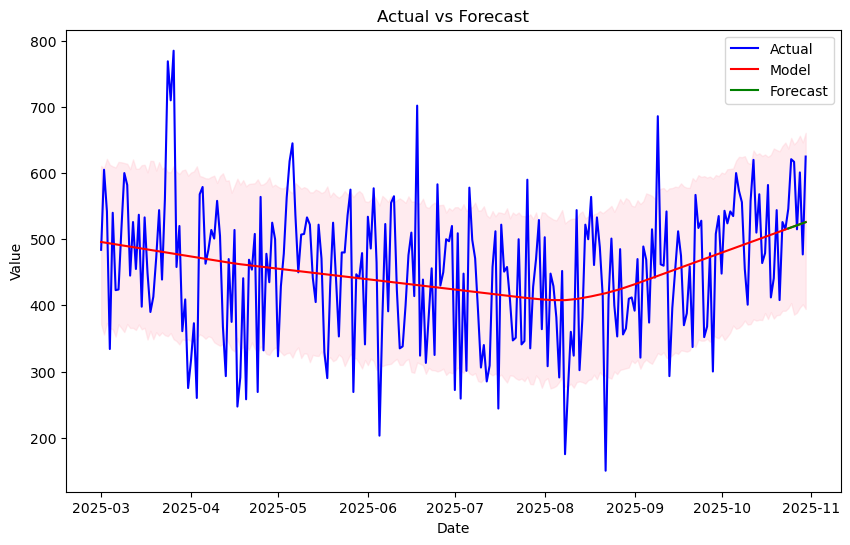

In [45]:
# Visualize time series plot
plt.figure(figsize=(10, 6))

plt.plot(prophet_df['ds'], prophet_df['y'], label='Actual', color='blue')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Model', color='red')
plt.plot(prophet_forecast['ds'].tail(7), prophet_forecast['yhat'].tail(7), label='Forecast', color='green')

# Fill the uncertainty interval (between yhat_lower and yhat_upper) with a color similar to the model's 
plt.fill_between(prophet_forecast['ds'], prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='pink', alpha=0.3)

plt.title('Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [46]:
prophet_pred = prophet_forecast[['ds', 'yhat']].iloc[-periods:]
prophet_pred.set_index('ds', inplace=True)
prophet_pred

yhat
ds                    
2025-10-24  516.281449
2025-10-25  517.874545
2025-10-26  519.467641
2025-10-27  521.060736
2025-10-28  522.653832
2025-10-29  524.246928
2025-10-30  525.840024

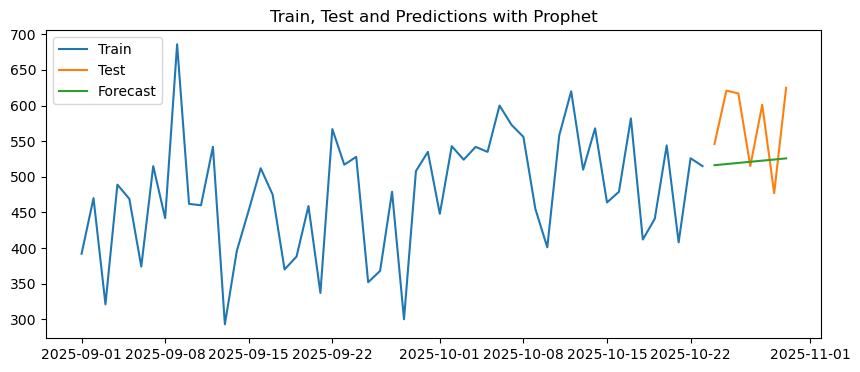

The RMSE is 74.90
The MAE is 65.88
The MAPE is 11.12 %


RMSE        MAE    MAPE
Prophet  74.900353  65.884311  0.1112

In [47]:
prophet_rmse, prophet_mae, prophet_mape = model_assessment(prophet_train.set_index('ds').loc['2025-09':], prophet_test.set_index('ds'), prophet_pred, 'Prophet')
prophet_metrics = pd.DataFrame(data={'RMSE': prophet_rmse, 'MAE': prophet_mae, 'MAPE': prophet_mape}, index=['Prophet'])
prophet_metrics

In [48]:
fig = plot_plotly(prophet_model, prophet_forecast)
py.iplot(fig)

The Prophet model fits a smooth curve with a quadratic-like trend and no visible structure or seasonality. Prophet seem to interpret the model as a gentle long-term drift with a quite stationary noise.<br> 
The model may perform even better if the seasonality or external regressors were applied.

# IN PROGRESS Neural networks

# IN PROGRESS Modeling forecast error using neural networks

# IN PROGRESS Modeling forecast error using GARCH

In [49]:
acorr_ljungbox(model_arima.resid**2, lags=10)

lb_stat  lb_pvalue
1   0.905911   0.341202
2   0.911940   0.633833
3   1.672776   0.643003
4   1.810898   0.770488
5   2.053991   0.841625
6   2.201611   0.900254
7   2.334623   0.939027
8   2.407019   0.965926
9   2.407049   0.983280
10  2.408141   0.992148

In [50]:
het_arch(model_arima.resid)

(7.485333754532614, 0.6789682995772033, 0.7365485498682156, 0.6895515021982302)

# Results summary

In [51]:
metrics = pd.concat([es_metrics, arima_metrics, prophet_metrics])
metrics

RMSE        MAE      MAPE
Simple ES  96.840758  84.090128  0.140075
Double ES  96.511850  83.809591  0.139619
Triple ES  92.246783  79.131003  0.131477
ARIMA      93.711411  80.167501  0.133352
Prophet    74.900353  65.884311  0.111200

In [52]:
print(
    f'Method with the lowest RMSE: {metrics['RMSE'].idxmin()}', 
    f'Method with the lowest MAE: {metrics['MAE'].idxmin()}', 
    f'Method with the lowest MAPE: {metrics['MAPE'].idxmin()}', 
    sep='\n'
     )

Method with the lowest RMSE: Prophet
Method with the lowest MAE: Prophet
Method with the lowest MAPE: Prophet


In [53]:
plt.figure(figsize = (10, 4))

plt.plot(df.loc['2025-10':], label = 'Real data')
#plt.plot(test.loc['2025-10':], label = 'Train')
plt.plot(ses_pred, label = 'Simple Exp Smoothing')
plt.plot(double_pred, label = "Double Exp Smoothing")
plt.plot(holt_pred, label = "Holt-Winters")
plt.plot(arima_pred, label = "ARIMA")
plt.plot(prophet_pred, label='Prophet')

plt.title(f"Real data and predictions for test part")
plt.legend()
plt.show()

The real data fluctuates heavily - large up-and-down movements and no consistent trend. Such irregularity makes it difficult for classical models (especially without seasonality or exogenous regressors) to capture the true dynamics. Most models therefore produce flat or slowly trending lines, which represent their “best guess” for a series with weak structure.<br>
Models’ performance suggests there is no systematic pattern to exploit - the irregular fluctuations are likely random or driven by external, unmodeled factors (e.g., varying dog activity, temperature, food measurement error, food type).<br>
Prophet model performs the best according to the selected error metrics. Exponential Smoothing methods and ARIMA achieved very similar metrics while Prophet's were clearly lower.

# Ideas of extending the analysis

<ul>
    <li>Including seasonality</li>
    <li>Adding regressors</li>
    <li>Selecting other methods</li>
    <li>Making hybrid models</li>
</ul>